In [47]:
import vice
import numpy as np
from numpy.random import default_rng
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import Normalize, LogNorm
from pathlib import Path
from sklearn.neighbors import KernelDensity

# Plot settings
plt.rcParams.update({
    'xtick.direction': 'in',
    'xtick.top': True,
    'ytick.direction': 'in',
    'ytick.right': True,
    'figure.dpi': 140,
    'figure.figsize': (4, 4),
    'font.family': 'STIXgeneral',
    'mathtext.fontset': 'cm',
    'legend.fontsize': 8,
})

In [8]:
def stars_dataframe(output_name):
    """
    Convert VICE milkyway stars output to pandas DataFrame.
    Includes z-height from analogdata.
    Takes a few seconds to run.
    """
    output = vice.output(output_name)
    stars = pd.DataFrame(dict(output.stars))
    analogdata = pd.read_csv('%s_analogdata.out' % output_name, sep='\t')
    # Limit analogdata to same max time as stars data
    tmax = max(output.stars['formation_time'])
    analogdata = analogdata[analogdata['time_origin'] <= tmax]
    # Combine relevant data
    stars[['analog_id', 'zfinal']] = analogdata[['analog_id', 'zfinal']]
    # Remove massless particles
    stars = stars[stars['mass'] > 0]
    return stars

def galactic_region(stars, galr_lim=(0, 20), absz_lim=(0, 5), zone_width=0.1):
    """
    Slice DataFrame of stars within a given Galactic region of radius and z-height.
    
    Parameters
    ----------
    stars : pandas DataFrame
        Output from stars_dataframe()
    galr_lim : tuple
        Minimum and maximum Galactic radius in kpc
    absz_lim : tuple
        Minimum and maximum of the absolute value of z-height in kpc
    zone_width : float
        Width of each simulation zone in kpc
    
    Returns
    -------
    pandas DataFrame
        Re-indexed DataFrame of stellar parameters
    """
    galr_min, galr_max = galr_lim
    absz_min, absz_max = absz_lim
    # Convert Galactic radius in kpc to zone #
    zone_min = galr_min / zone_width
    zone_max = galr_max / zone_width
    # Select subset
    subset = stars[(stars['zone_final'] >= zone_min) & 
                   (stars['zone_final'] < zone_max) & 
                   (stars['zfinal'].abs() >= absz_min) &
                   (stars['zfinal'].abs() < absz_max)]
    subset.reset_index(inplace=True)
    return subset

def sample_stars(stars, n):
    """
    Randomly sample n stars from VICE output.
    
    Parameters
    ----------
    stars : pandas DataFrame
        Output of stars_dataframe()
    n : Number of random samples
    
    Returns
    -------
    pandas DataFrame
        Re-indexed DataFrame of stellar parameters
    """
    # Initialize default numpy random number generator
    rng = default_rng()
    # Randomly sample without replacement
    rand_indices = rng.choice(stars.index, size=n, replace=False)
    sample = stars.loc[rand_indices]
    return sample.reset_index()

def abundance_gridplot(stars, hist, galr_bins=[3, 5, 7, 9, 11, 13], absz_bins=[0, 0.5, 1, 2], 
                       zone_width=0.1, xlim=(-1.3, 0.8), ylim=None, cmap_name='winter',
                       title=''):
    """
    Plot a grid of [O/Fe] vs [Fe/H] panels binned by galactic radius and z-height.
    
    Takes a few seconds to run.
    
    Parameters
    ----------
    stars : pandas DataFrame
        Output of stars_dataframe()
    hist : VICE dataframe
        Output of vice.history() for a single zone. Acts as a reference abundance
        track which is plotted the same in every panel
    galr_bins : list, default: [3, 5, 7, 9, 11, 13]
        Lower and upper limits of bins in galactic radius in kpc
    absz_bins : list, default: [0, 0.5, 1, 2]
        Lower and upper limits of bins in absolute galactic z-height in kpc
    zone_width : float, default: 0.1
        Width of each Milky Way annulus in kpc
    xlim : tuple, default: (-1.3, 0.8)
        Limits of x-axes
    ylim : tuple, default: None
        Limits of y-axes
    cmap_name : string, default: 'winter'
        Name of colormap to use for galactic radius of origin
    """
    fig, axs = plt.subplots(len(absz_bins), len(galr_bins), figsize=(13, 8), sharex=True, sharey=True)
    # Set up colorbar for radius of origin
    subset = galactic_region(stars, galr_lim=(galr_bins[0], galr_bins[-1]),
                             absz_lim=(absz_bins[0], absz_bins[-1]), zone_width=zone_width)
    cmap = mpl.cm.get_cmap(cmap_name)
    norm = mpl.colors.Normalize(vmin=0, vmax=subset['zone_origin'].max() * zone_width)
    # Scatter plots in all panels
    for i, row in enumerate(axs):
        absz_lim = (absz_bins[-(i+2)], absz_bins[-(i+1)])
        for j, ax in enumerate(row):
            galr_lim = (galr_bins[j], galr_bins[j+1])
            subset = galactic_region(stars, galr_lim, absz_lim, zone_width)
            sample = sample_stars(subset, 10000)
            # Scatter plot of random sample of stellar particles
            pc = ax.scatter(sample['[fe/h]'], sample['[o/fe]'], s=0.1, 
                            c=sample['zone_origin'] * zone_width, cmap=cmap, norm=norm)
            # Plot reference abundance tracks
            ax.plot(hist['[fe/h]'], hist['[o/fe]'], c='k')
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            ax.xaxis.set_major_locator(MultipleLocator(0.5))
            ax.xaxis.set_minor_locator(MultipleLocator(0.1))
            ax.yaxis.set_minor_locator(MultipleLocator(0.02))
            # Label axes
            if i == len(axs)-1:
                ax.set_xlabel('[Fe/H]')
            if j == 0:
                ax.set_ylabel('[O/Fe]')
                ax.text(0.55, 0.85, r'$%s\leq |z| < %s$' % absz_lim, transform=ax.transAxes)
            if i == 0:
                ax.set_title(r'$%s\leq R_{\rm{Gal}} < %s$ kpc'% galr_lim)
    # Plot colorbar
    plt.subplots_adjust(right=0.9, wspace=0.05, hspace=0.05)
    cax = plt.axes([0.91, 0.125, 0.02, 0.755])
    cbar = plt.colorbar(pc, cmap=cmap, norm=norm, cax=cax)
    cax.yaxis.set_minor_locator(MultipleLocator(0.5))
    cbar.set_label(r'Birth $R_{\rm{Gal}}$ [kpc]')
    # Plot title
    if len(title) > 0:
        fig.suptitle(title)
    plt.show()

## Standard Power-Law (-1.1 slope)

In [4]:
stars = stars_dataframe('../src/data/migration_outputs/diffusion/insideout/powerlaw')
stars

,formation_time,zone_origin,zone_final,mass,z(fe),z(o),[fe/h],[o/h],[o/fe],z,[m/h],age,analog_id,zfinal
1600,0.01,0.0,52.0,125.7098,0.000004,0.000045,-2.557639,-2.107535,0.450104,0.000096,-2.162433,13.19,26928735,0.48
1601,0.01,0.0,33.0,125.7098,0.000004,0.000045,-2.557639,-2.107535,0.450104,0.000096,-2.162433,13.19,26926858,2.74
1602,0.01,0.0,17.0,125.7098,0.000004,0.000045,-2.557639,-2.107535,0.450104,0.000096,-2.162433,13.19,26925158,-1.76
1603,0.01,0.0,22.0,125.7098,0.000004,0.000045,-2.557639,-2.107535,0.450104,0.000096,-2.162433,13.19,26930124,-2.55
1604,0.01,0.0,33.0,125.7098,0.000004,0.000045,-2.557639,-2.107535,0.450104,0.000096,-2.162433,13.19,26926858,2.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2113235,13.20,154.0,154.0,3698.4550,0.000224,0.001364,-0.761097,-0.622726,0.138371,0.003170,-0.645098,0.00,35021980,0.71
2113236,13.20,154.0,154.0,3698.4550,0.000224,0.001364,-0.761097,-0.622726,0.138371,0.003170,-0.645098,0.00,34981832,0.08
2113237,13.20,154.0,154.0,3698.4550,0.000224,0.001364,-0.761097,-0.622726,0.138371,0.003170,-0.645098,0.00,35013753,-0.42
2113238,13.20,154.0,154.0,3698.4550,0.000224,0.001364,-0.761097,-0.622726,0.138371,0.003170,-0.645098,0.00,35016183,-0.22


In [6]:
# Get ISM tracks for mean galr in post-processing
post_process = vice.output('../src/data/migration_outputs/post-process/insideout/powerlaw')
solar_hist = post_process.zones['zone80'].history

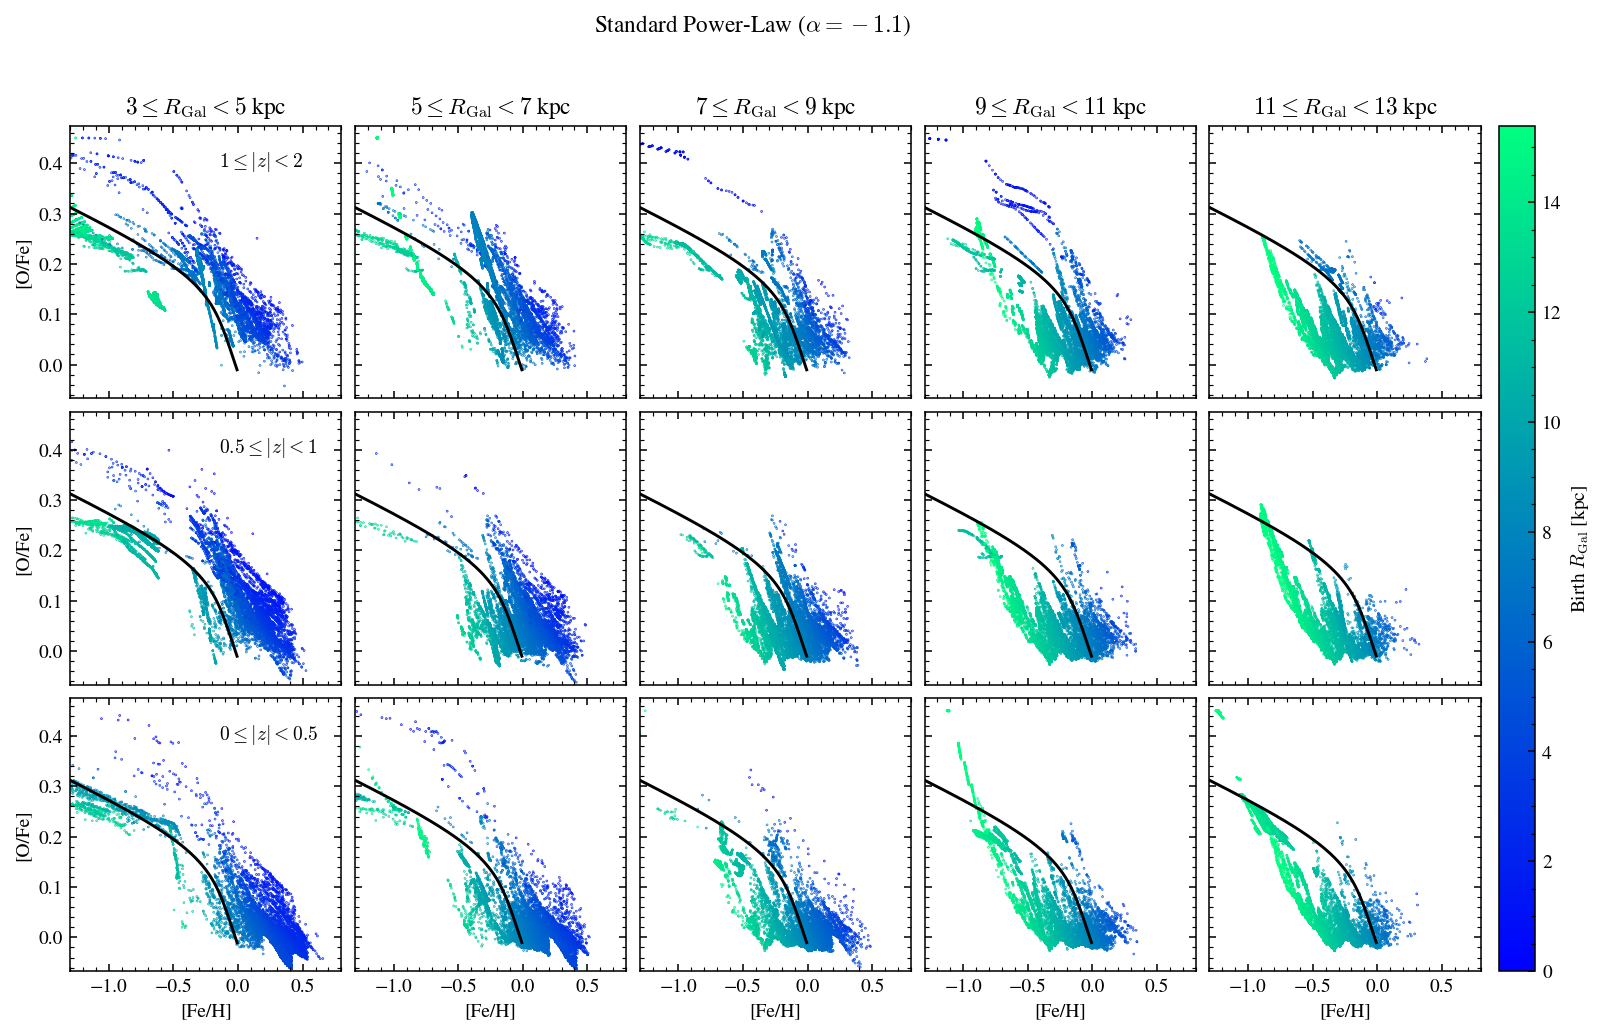

In [9]:
abundance_gridplot(stars, solar_hist, title=r'Standard Power-Law ($\alpha=-1.1$)')

## 150 Myr Minimum Delay

In [10]:
stars = stars_dataframe('../src/data/migration_outputs/diffusion/insideout/long_delay')
stars

,formation_time,zone_origin,zone_final,mass,z(fe),z(o),[fe/h],[o/h],[o/fe],z,[m/h],age,analog_id,zfinal
1600,0.01,0.0,60.0,125.7098,0.000004,0.000045,-2.557639,-2.107535,0.450104,0.000096,-2.162433,13.19,26926593,0.91
1601,0.01,0.0,30.0,125.7098,0.000004,0.000045,-2.557639,-2.107535,0.450104,0.000096,-2.162433,13.19,26924690,1.00
1602,0.01,0.0,34.0,125.7098,0.000004,0.000045,-2.557639,-2.107535,0.450104,0.000096,-2.162433,13.19,26929262,-1.37
1603,0.01,0.0,42.0,125.7098,0.000004,0.000045,-2.557639,-2.107535,0.450104,0.000096,-2.162433,13.19,26930426,-0.25
1604,0.01,0.0,34.0,125.7098,0.000004,0.000045,-2.557639,-2.107535,0.450104,0.000096,-2.162433,13.19,26929262,-1.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2113235,13.20,154.0,154.0,3698.4550,0.000241,0.001368,-0.728597,-0.621347,0.107250,0.003213,-0.639197,0.00,34968353,0.04
2113236,13.20,154.0,154.0,3698.4550,0.000241,0.001368,-0.728597,-0.621347,0.107250,0.003213,-0.639197,0.00,35001433,0.19
2113237,13.20,154.0,154.0,3698.4550,0.000241,0.001368,-0.728597,-0.621347,0.107250,0.003213,-0.639197,0.00,35018220,-0.50
2113238,13.20,154.0,154.0,3698.4550,0.000241,0.001368,-0.728597,-0.621347,0.107250,0.003213,-0.639197,0.00,34967556,0.24


In [11]:
# Get ISM tracks for mean galr in post-processing
post_process = vice.output('../src/data/migration_outputs/post-process/insideout/long_delay')
solar_hist = post_process.zones['zone80'].history

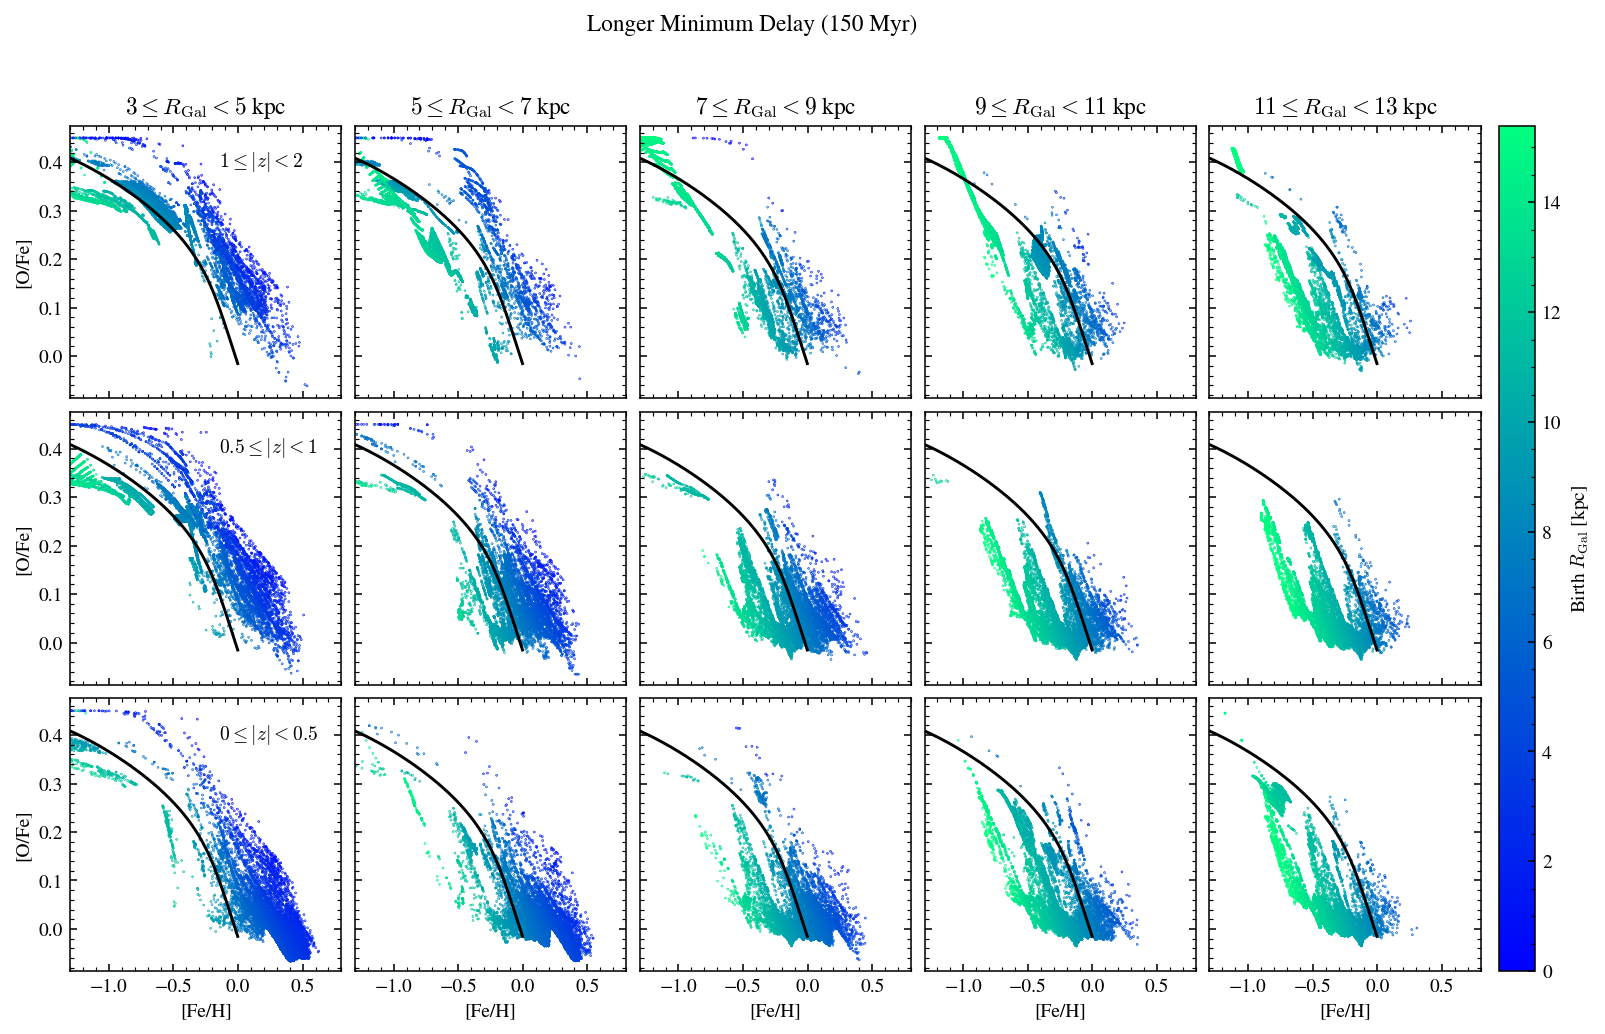

In [12]:
abundance_gridplot(stars, solar_hist, title='Longer Minimum Delay (150 Myr)')

## Steep Power-Law (-1.4 slope)

In [13]:
stars = stars_dataframe('../src/data/migration_outputs/diffusion/insideout/powerlaw_steep')
stars

,formation_time,zone_origin,zone_final,mass,z(fe),z(o),[fe/h],[o/h],[o/fe],z,[m/h],age,analog_id,zfinal
1600,0.01,0.0,39.0,125.7098,0.000004,0.000045,-2.557639,-2.107535,0.450104,0.000096,-2.162433,13.19,26926680,0.94
1601,0.01,0.0,33.0,125.7098,0.000004,0.000045,-2.557639,-2.107535,0.450104,0.000096,-2.162433,13.19,26928340,-0.59
1602,0.01,0.0,18.0,125.7098,0.000004,0.000045,-2.557639,-2.107535,0.450104,0.000096,-2.162433,13.19,26926792,-0.14
1603,0.01,0.0,18.0,125.7098,0.000004,0.000045,-2.557639,-2.107535,0.450104,0.000096,-2.162433,13.19,26928730,-0.30
1604,0.01,0.0,30.0,125.7098,0.000004,0.000045,-2.557639,-2.107535,0.450104,0.000096,-2.162433,13.19,26926678,0.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2113235,13.20,154.0,154.0,3698.4550,0.000227,0.001365,-0.753883,-0.622380,0.131503,0.003179,-0.643778,0.00,35015193,0.58
2113236,13.20,154.0,154.0,3698.4550,0.000227,0.001365,-0.753883,-0.622380,0.131503,0.003179,-0.643778,0.00,34970747,-0.29
2113237,13.20,154.0,154.0,3698.4550,0.000227,0.001365,-0.753883,-0.622380,0.131503,0.003179,-0.643778,0.00,35029724,-0.33
2113238,13.20,154.0,154.0,3698.4550,0.000227,0.001365,-0.753883,-0.622380,0.131503,0.003179,-0.643778,0.00,34979857,-0.89


In [15]:
# Get ISM tracks for mean galr in post-processing
post_process = vice.output('../src/data/migration_outputs/post-process/insideout/powerlaw_steep')
solar_hist = post_process.zones['zone80'].history

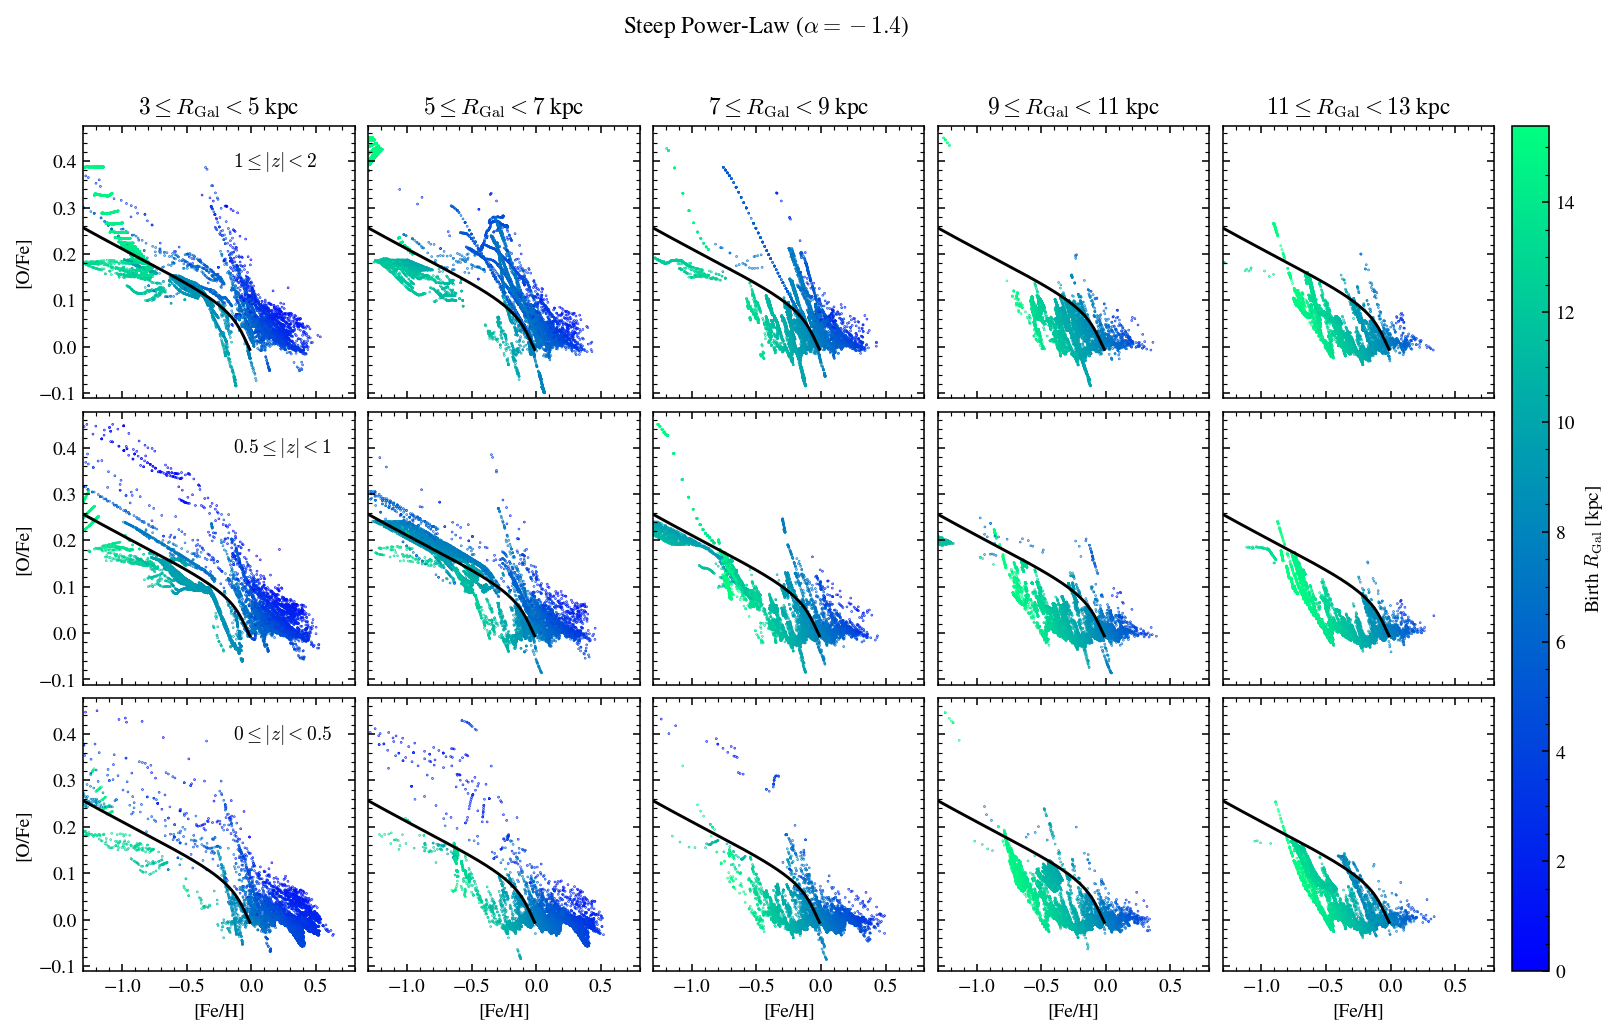

In [17]:
abundance_gridplot(stars, solar_hist, title=r'Steep Power-Law ($\alpha=-1.4$)')

## Exponential (1.5 Gyr timescale)

In [18]:
stars = stars_dataframe('../src/data/migration_outputs/diffusion/insideout/exponential')
stars

,formation_time,zone_origin,zone_final,mass,z(fe),z(o),[fe/h],[o/h],[o/fe],z,[m/h],age,analog_id,zfinal
1600,0.01,0.0,18.0,125.7098,0.000004,0.000045,-2.557639,-2.107535,0.450104,0.000096,-2.162433,13.19,26928890,-1.65
1601,0.01,0.0,39.0,125.7098,0.000004,0.000045,-2.557639,-2.107535,0.450104,0.000096,-2.162433,13.19,26930455,0.05
1602,0.01,0.0,18.0,125.7098,0.000004,0.000045,-2.557639,-2.107535,0.450104,0.000096,-2.162433,13.19,26928890,-1.65
1603,0.01,0.0,31.0,125.7098,0.000004,0.000045,-2.557639,-2.107535,0.450104,0.000096,-2.162433,13.19,26930444,2.24
1604,0.01,0.0,41.0,125.7098,0.000004,0.000045,-2.557639,-2.107535,0.450104,0.000096,-2.162433,13.19,26930475,-1.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2113235,13.20,154.0,154.0,3698.4550,0.000245,0.001365,-0.721096,-0.622291,0.098804,0.003216,-0.638866,0.00,35019893,-0.00
2113236,13.20,154.0,154.0,3698.4550,0.000245,0.001365,-0.721096,-0.622291,0.098804,0.003216,-0.638866,0.00,34967400,-0.22
2113237,13.20,154.0,154.0,3698.4550,0.000245,0.001365,-0.721096,-0.622291,0.098804,0.003216,-0.638866,0.00,35022724,-0.42
2113238,13.20,154.0,154.0,3698.4550,0.000245,0.001365,-0.721096,-0.622291,0.098804,0.003216,-0.638866,0.00,35024028,-0.79


In [19]:
# Get ISM tracks for mean galr in post-processing
post_process = vice.output('../src/data/migration_outputs/post-process/insideout/exponential')
solar_hist = post_process.zones['zone80'].history

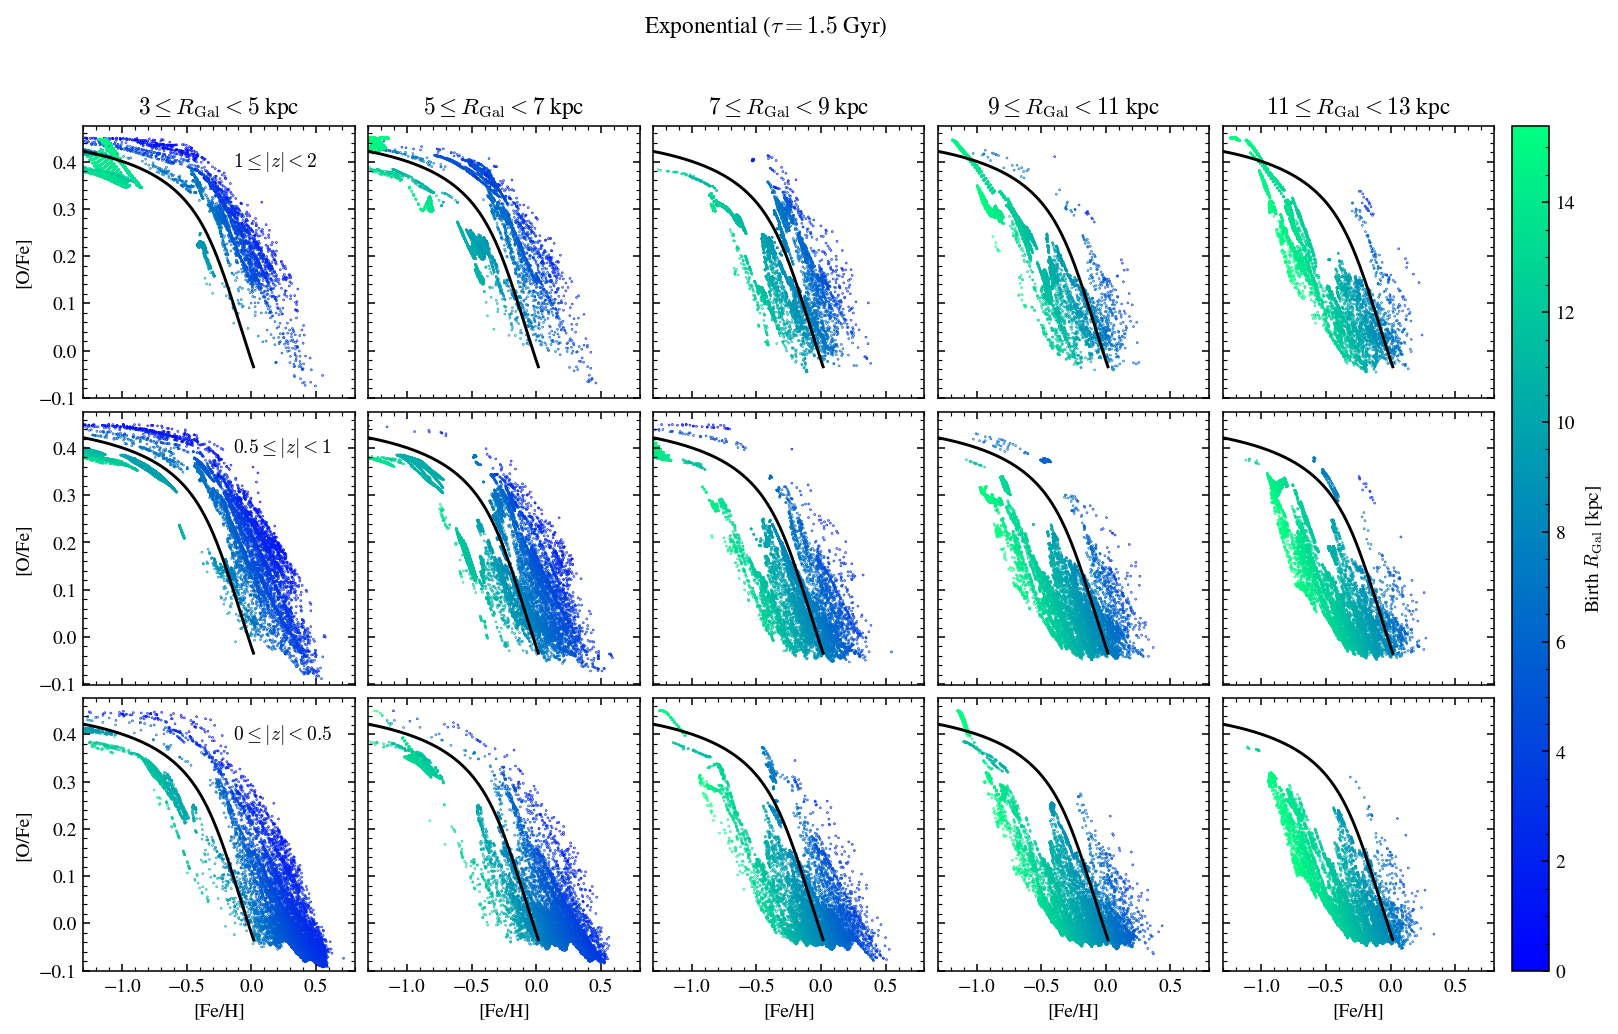

In [20]:
abundance_gridplot(stars, solar_hist, title=r'Exponential ($\tau=1.5$ Gyr)')

## Comparison with APOGEE data

In [23]:
apogee_path = Path('../src/data/APOGEE')
data_file = 'dr17_cut_data.csv'
data = pd.read_csv(apogee_path / data_file)
data

,APOGEE_ID,TELESCOPE,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,...,APOKASC2_AGE,APOKASC2_AGE_PERR,APOKASC2_AGE_MERR,APOKASC2_AV,APOKASC2_AV_ERR,APOKASC2_NOTE,APOK2_MASS,APOK2_MASS_ERR,APOK2_RADIUS,APOK2_RADIUS_ERR
0,2M00000002+7417074,apo25m,120+12,none,0.000103,74.285408,119.401807,11.767414,8.597,0.039,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN
1,2M00000032+5737103,apo25m,N7789,none,0.001335,57.619530,116.065371,-4.564768,10.905,0.023,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN
2,2M00000035-7323394,lco25m,SMC12,none,0.001467,-73.394287,307.939441,-43.230305,15.008,0.045,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN
3,2M00000068+5710233,apo25m,N7789,none,0.002850,57.173164,115.977154,-5.002392,10.664,0.023,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN
4,2M00000133+5721163,apo25m,NGC7789_btx,none,0.005558,57.354549,116.014776,-4.824917,13.261,0.029,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408656,2M23595867-7339039,lco25m,SMC12,none,359.994493,-73.651093,307.846602,-42.982597,15.671,0.069,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN
408657,2M23595886+5726058,apo25m,116-04,none,359.995265,57.434956,116.025359,-4.745011,11.466,0.024,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN
408658,2M23595921+5609479,apo25m,NGC7789_MGA,none,359.996744,56.163330,115.771964,-5.991363,11.985,0.023,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN
408659,2M23595949-7342592,lco25m,SMC12,none,359.997887,-73.716454,307.821174,-42.919934,15.924,0.094,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN


In [44]:
def apogee_region(data, galr_lim=(0, 20), absz_lim=(0, 5)):
    """
    Slice astroNN data within a given Galactic region of radius and z-height.
    
    Parameters
    ----------
    stars : pandas DataFrame
        Output from stars_dataframe()
    galr_lim : tuple
        Minimum and maximum Galactic radius in kpc
    absz_lim : tuple
        Minimum and maximum of the absolute value of z-height in kpc
    zone_width : float
        Width of each simulation zone in kpc
    
    Returns
    -------
    pandas DataFrame
        Re-indexed DataFrame of stellar parameters
    """
    galr_min, galr_max = galr_lim
    absz_min, absz_max = absz_lim
    # Select subset
    subset = data[(data['ASTRONN_GALR'] >= galr_min) & 
                  (data['ASTRONN_GALR'] < galr_max) & 
                  (data['ASTRONN_GALZ'].abs() >= absz_min) &
                  (data['ASTRONN_GALZ'].abs() < absz_max)]
    subset.reset_index(inplace=True)
    return subset.dropna(subset='O_FE')


def kde2D(x, y, bandwidth, xbins=100j, ybins=100j, **kwargs): 
    """Build 2D kernel density estimate (KDE)."""

    # create grid of sample locations (default: 100x100)
    xx, yy = np.mgrid[x.min():x.max():xbins, 
                      y.min():y.max():ybins]

    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = np.vstack([y, x]).T

    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(xy_train)

    # score_samples() returns the log-likelihood of the samples
    z = np.exp(kde_skl.score_samples(xy_sample))
    return xx, yy, np.reshape(z, xx.shape)

In [25]:
stars = stars_dataframe('../src/data/migration_outputs/diffusion/insideout/long_delay')

In [26]:
# Get ISM tracks for mean galr in post-processing
post_process = vice.output('../src/data/migration_outputs/post-process/insideout/powerlaw')
solar_hist = post_process.zones['zone80'].history

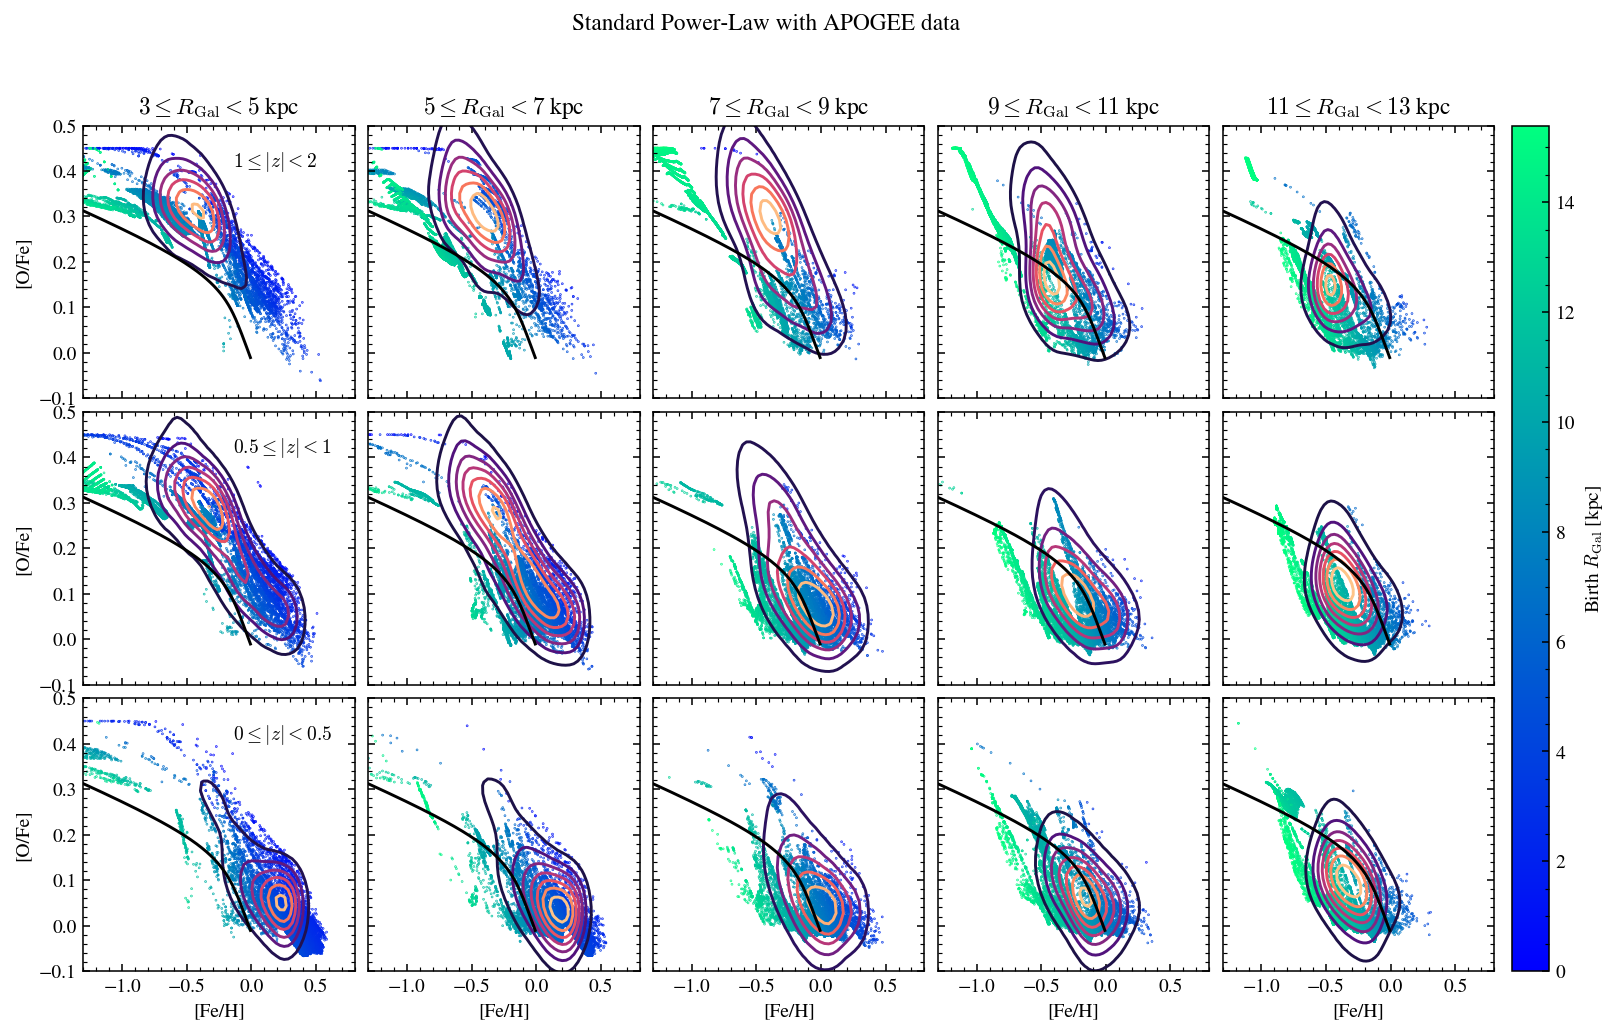

In [48]:
galr_bins=[3, 5, 7, 9, 11, 13]
absz_bins=[0, 0.5, 1, 2]
zone_width=0.1
xlim=(-1.3, 0.8)
ylim=(-0.1, 0.5)
nbins = 20
cmap_name='winter'
title='Standard Power-Law with APOGEE data'

fig, axs = plt.subplots(3, 5, figsize=(13, 8), sharex=True, sharey=True)
# Set up colorbar for radius of origin
subset = galactic_region(stars, galr_lim=(galr_bins[0], galr_bins[-1]),
                         absz_lim=(absz_bins[0], absz_bins[-1]), zone_width=zone_width)
cmap = mpl.cm.get_cmap(cmap_name)
norm = mpl.colors.Normalize(vmin=0, vmax=subset['zone_origin'].max() * zone_width)
# Scatter plots in all panels
for i, row in enumerate(axs):
    absz_lim = (absz_bins[-(i+2)], absz_bins[-(i+1)])
    for j, ax in enumerate(row):
        galr_lim = (galr_bins[j], galr_bins[j+1])
        # 2D histogram of APOGEE data
        apogee_subset = apogee_region(data, galr_lim, absz_lim)
        xx, yy, zz = kde2D(apogee_subset['FE_H'], apogee_subset['O_FE'], 0.05)
        ax.contour(xx, yy, zz, cmap='magma')
        # Select and sample simulated star particles
        subset = galactic_region(stars, galr_lim, absz_lim, zone_width)
        sample = sample_stars(subset, 10000)
        # Scatter plot of random sample of stellar particles
        pc = ax.scatter(sample['[fe/h]'], sample['[o/fe]'], s=0.1, 
                        c=sample['zone_origin'] * zone_width, cmap=cmap, norm=norm)
        # Plot reference abundance tracks
        ax.plot(solar_hist['[fe/h]'], solar_hist['[o/fe]'], c='k')
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.xaxis.set_major_locator(MultipleLocator(0.5))
        ax.xaxis.set_minor_locator(MultipleLocator(0.1))
        ax.yaxis.set_minor_locator(MultipleLocator(0.02))
        # Label axes
        if i == len(axs)-1:
            ax.set_xlabel('[Fe/H]')
        if j == 0:
            ax.set_ylabel('[O/Fe]')
            ax.text(0.55, 0.85, r'$%s\leq |z| < %s$' % absz_lim, transform=ax.transAxes)
        if i == 0:
            ax.set_title(r'$%s\leq R_{\rm{Gal}} < %s$ kpc'% galr_lim)
# Plot colorbar
plt.subplots_adjust(right=0.9, wspace=0.05, hspace=0.05)
cax = plt.axes([0.91, 0.125, 0.02, 0.755])
cbar = plt.colorbar(pc, cmap=cmap, norm=norm, cax=cax)
cax.yaxis.set_minor_locator(MultipleLocator(0.5))
cbar.set_label(r'Birth $R_{\rm{Gal}}$ [kpc]')
# Plot title
if len(title) > 0:
    fig.suptitle(title)
plt.show()